In [3]:
import numpy as np
import ewtpy
from scipy.io import loadmat
from scipy.stats import skew, kurtosis

# Load EEG data from the MATLAB file
mat_data = loadmat('stress_class\Mirror_image_sub_9_trial3.mat')
eeg_data = mat_data['Data']

# Convert the data to a NumPy array
signal = eeg_data.astype(float)

# Preprocess the signal if needed
if len(eeg_data.shape) > 1:
    f = eeg_data[:, 0]
else:
    f = eeg_data
    
f = f - np.mean(f)

# Set parameters
N = 5  # number of supports
detect = "locmax"  # detection mode: locmax, locmaxmin, locmaxminf
reg = 'gaussian'  # spectrum regularization - it is smoothed with an average (or gaussian) filter
lengthFilter = 25  # length or average or gaussian filter
sigmaFilter = 0  # sigma of gaussian filter

# Perform EWT
ewt,  mfb ,boundaries = ewtpy.EWT1D(f, 
                                    N = N,
                                    log = 0,
                                    detect = detect, 
                                    completion = 0, 
                                    reg = reg, 
                                    lengthFilter = lengthFilter,
                                    sigmaFilter = sigmaFilter)

# Extract features from each EWT mode
for i, mode in enumerate(ewt.T):
    # Example features:
    mean_value = np.mean(mode)
    std_deviation = np.std(mode)
    max_amplitude = np.max(mode)
    min_amplitude = np.min(mode)
    skewness = skew(mode)
    kurt = kurtosis(mode)

    print(f"Features for EWT Mode {i + 1}:")
    print(f"Mean: {mean_value}")
    print(f"Standard Deviation: {std_deviation}")
    print(f"Max Amplitude: {max_amplitude}")
    print(f"Min Amplitude: {min_amplitude}")
    print(f"Skewness: {skewness}")
    print(f"Kurtosis: {kurt}")
    print("-----------------")

Features for EWT Mode 1:
Mean: 0.45090389806628584
Standard Deviation: 19.21179718422807
Max Amplitude: 29.669387183300508
Min Amplitude: -40.08917111921715
Skewness: -0.6853210190402178
Kurtosis: -0.42241816445136715
-----------------
Features for EWT Mode 2:
Mean: -0.27973037440591053
Standard Deviation: 25.64807204890471
Max Amplitude: 76.25001951401143
Min Amplitude: -69.49001701809966
Skewness: -0.003554014077175121
Kurtosis: 2.811880405073797
-----------------
Features for EWT Mode 3:
Mean: -0.08664395598473346
Standard Deviation: 6.0971391989232915
Max Amplitude: 17.18838277557538
Min Amplitude: -12.52428678164211
Skewness: 0.42821220462388443
Kurtosis: 1.2960467059514915
-----------------
Features for EWT Mode 4:
Mean: -0.08452956767564068
Standard Deviation: 2.138792745194782
Max Amplitude: 4.604348624329131
Min Amplitude: -5.4098923312410045
Skewness: -0.1342317817081389
Kurtosis: 0.2344211704649748
-----------------
Features for EWT Mode 5:
Mean: 0.0
Standard Deviation: 0.0


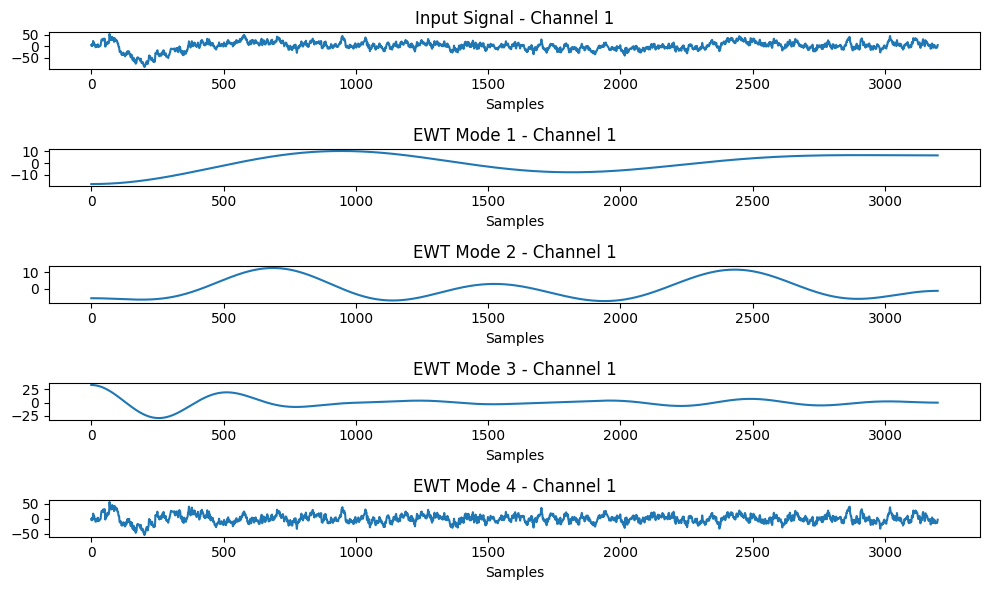

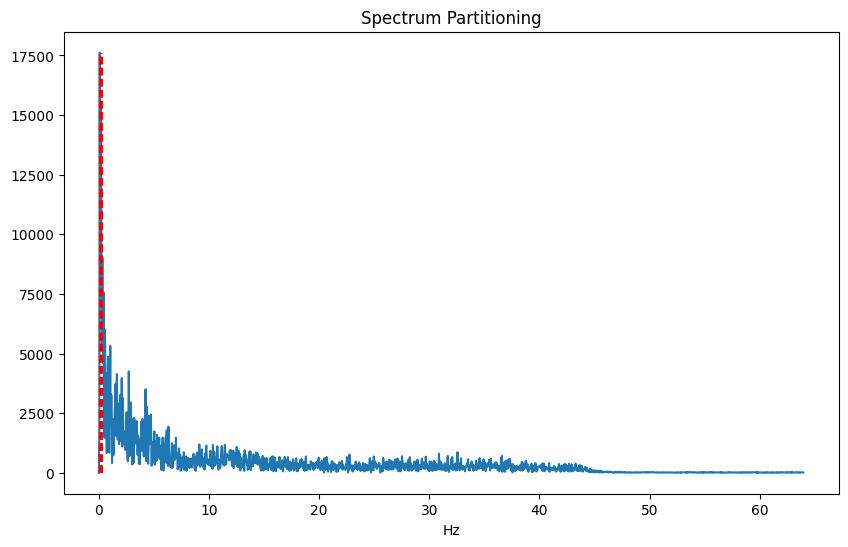

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import ewtpy
from scipy.io import loadmat

# Load EEG data from the MATLAB file
mat_data = loadmat('stress_class\Mirror_image_sub_9_trial3.mat')
eeg_data = mat_data['Data']

# Convert the data to a NumPy array
signal = eeg_data.astype(float)

# Get the number of channels and samples
num_channels, num_samples = signal.shape

# Select the channel you want to analyze (adjust channel_index accordingly)
channel_index = 0
channel_data = signal[channel_index, :]

# Preprocess the signal if needed
channel_data = channel_data - np.mean(channel_data)

# Set parameters
N = 4  # number of supports
detect = "locmax"  # detection mode: locmax, locmaxmin, locmaxminf
reg = 'gaussian'  # spectrum regularization - it is smoothed with an average (or gaussian) filter
lengthFilter = 25  # length or average or gaussian filter
sigmaFilter = 0  # sigma of gaussian filter
Fs = 128  # sampling frequency, in Hz (if unknown, set -1)

# Perform EWT for the selected channel
ewt, mfb, boundaries = ewtpy.EWT1D(channel_data,
                                   N=N,
                                   log=0,
                                   detect=detect,
                                   completion=0,
                                   reg=reg,
                                   lengthFilter=lengthFilter,
                                   sigmaFilter=sigmaFilter)

# Plot input signal
plt.figure(figsize=(10, 6))
plt.subplot(len(ewt.T) + 1, 1, 1)
plt.plot(channel_data)
plt.title(f'Input Signal - Channel {channel_index + 1}')
plt.xlabel('Samples')

# Plot each EWT mode in a separate subplot
for i, mode in enumerate(ewt.T):
    plt.subplot(len(ewt.T) + 1, 1, i + 2)
    plt.plot(mode)
    plt.title(f'EWT Mode {i + 1} - Channel {channel_index + 1}')
    plt.xlabel('Samples')

plt.tight_layout()
plt.show()

# Show boundaries on the spectrum
plt.figure(figsize=(10, 6))
ff = np.fft.fft(channel_data)
freq = 2 * np.pi * np.arange(0, len(ff)) / len(ff)

if Fs != -1:
    freq = freq * Fs / (2 * np.pi)
    boundariesPLT = boundaries * Fs / (2 * np.pi)
else:
    boundariesPLT = boundaries

ff = np.abs(ff[: ff.size // 2])  # one-sided magnitude
freq = freq[: freq.size // 2]

plt.plot(freq, ff)
for bb in boundariesPLT:
    plt.plot([bb, bb], [0, max(ff)], 'r--')
plt.title('Spectrum Partitioning')
plt.xlabel('Hz')
plt.show()

# Calculate energy for each EWT mode
energy = np.sum(ewt ** 2, axis=0)




In [13]:
import os
import numpy as np
import pandas as pd
from scipy.stats import entropy
from scipy.signal import find_peaks
import ewtpy
import matplotlib.pyplot as plt
from scipy.io import loadmat

# Function to compute spectral energy
def compute_spectral_energy(signal, fs):
    fft_values = np.fft.fft(signal)
    magnitude = np.abs(fft_values)
    energy = np.sum(magnitude ** 2) / len(signal)
    return energy

# Function to compute AM (Amplitude Modulation)
def compute_amplitude_modulation(signal):
    return np.mean(np.abs(np.diff(signal)))

# Function to compute BM (Frequency Modulation)
def compute_frequency_modulation(signal, fs):
    phase = np.unwrap(np.angle(signal))
    frequency = np.diff(phase) / (2 * np.pi) * fs
    return np.mean(np.abs(np.diff(frequency)))

# Function to compute Hjorth mobility and complexity
def compute_hjorth_parameters(signal):
    diff1 = np.diff(signal)
    diff2 = np.diff(diff1)

    activity = np.var(signal)
    mobility = np.sqrt(np.var(diff1) / activity) if activity > 0 else 0
    complexity = np.sqrt(np.var(diff2) / np.var(diff1)) if np.var(diff1) > 0 else 0

    return mobility, complexity

# Set parameters
N = 4  # number of supports
detect = "locmax"  # detection mode: locmax, locmaxmin, locmaxminf
reg = 'gaussian'  # spectrum regularization - it is smoothed with an average (or gaussian) filter
lengthFilter = 25  # length or average or gaussian filter
sigmaFilter = 0  # sigma of gaussian filter
Fs = 128  # sampling frequency, in Hz (if unknown, set -1)

# Create an empty list to store features for label 0 and label 1
features_all = []

# Iterate over each subject
for subject_id in range(1, num_subjects + 1):
    # Load data for the current subject and class (Relaxation)
    relax_data = loadmat(os.path.join('stress_class', f'Mirror_image_sub_{subject_id}_trial3.mat'))
    normal_data = loadmat(os.path.join('normal_class', f'Relax_sub_{subject_id}_trial3.mat'))

    # Extract signals for Relaxation and stress classes
    selected_channels = [0] 
    relax_signal = relax_data['Data'].astype(float)[selected_channels, :]
    normal_signal = normal_data['Clean_data'].astype(float)[selected_channels, :]

    # Perform EWT for the Relaxation class
    relax_ewt, _, _ = ewtpy.EWT1D(relax_signal[channel_index, :],
                                  N=N,
                                  log=0,
                                  detect=detect,
                                  completion=0,
                                  reg=reg,
                                  lengthFilter=lengthFilter,
                                  sigmaFilter=sigmaFilter)

    # Perform EWT for the stress class
    normal_ewt, _, _ = ewtpy.EWT1D(normal_signal[channel_index, :],
                                   N=N,
                                   log=0,
                                   detect=detect,
                                   completion=0,
                                   reg=reg,
                                   lengthFilter=lengthFilter,
                                   sigmaFilter=sigmaFilter)
    num_subjects = 20
    # Iterate over each mode
    for mode_index in range(num_ewt_modes):
        # Get the EWT mode for the current subject
        relax_mode = relax_ewt[mode_index, :]
        normal_mode = normal_ewt[mode_index, :]

        # Feature extraction for Relaxation class
        relax_energy = compute_spectral_energy(relax_mode, Fs)
        relax_amplitude_modulation = compute_amplitude_modulation(relax_mode)
        relax_frequency_modulation = compute_frequency_modulation(relax_mode, Fs)
        relax_mobility, relax_complexity = compute_hjorth_parameters(relax_mode)

        # Feature extraction for Stress class
        stress_energy = compute_spectral_energy(normal_mode, Fs)
        stress_amplitude_modulation = compute_amplitude_modulation(normal_mode)
        stress_frequency_modulation = compute_frequency_modulation(normal_mode, Fs)
        stress_mobility, stress_complexity = compute_hjorth_parameters(normal_mode)

        # Append features to the list
        features_all.append([
            relax_energy, relax_amplitude_modulation, relax_frequency_modulation,
            relax_mobility, relax_complexity, 0
        ])

        features_all.append([
            stress_energy, stress_amplitude_modulation, stress_frequency_modulation,
            stress_mobility, stress_complexity, 1
        ])

# Save all features to a CSV file
columns = ['Energy', 'Amplitude_Modulation', 'Frequency_Modulation', 'Mobility', 'Complexity', 'Label']
df_all = pd.DataFrame(features_all, columns=columns)
df_all.to_csv('all_features.csv', index=False)
print("All features saved.")



All features saved.


In [14]:
import os
import numpy as np
import pandas as pd
from scipy.stats import entropy
from scipy.signal import find_peaks
import ewtpy
import matplotlib.pyplot as plt
from scipy.io import loadmat
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict

# Function to compute spectral energy
def compute_spectral_energy(signal, fs):
    fft_values = np.fft.fft(signal)
    magnitude = np.abs(fft_values)
    energy = np.sum(magnitude ** 2) / len(signal)
    return energy

# Function to compute AM (Amplitude Modulation)
def compute_amplitude_modulation(signal):
    return np.mean(np.abs(np.diff(signal)))

# Function to compute BM (Frequency Modulation)
def compute_frequency_modulation(signal, fs):
    phase = np.unwrap(np.angle(signal))
    frequency = np.diff(phase) / (2 * np.pi) * fs
    return np.mean(np.abs(np.diff(frequency)))

# Function to compute Hjorth mobility and complexity
def compute_hjorth_parameters(signal):
    diff1 = np.diff(signal)
    diff2 = np.diff(diff1)

    activity = np.var(signal)
    mobility = np.sqrt(np.var(diff1) / activity) if activity > 0 else 0
    complexity = np.sqrt(np.var(diff2) / np.var(diff1)) if np.var(diff1) > 0 else 0

    return mobility, complexity

# Set parameters
N = 4  # number of supports
detect = "locmax"  # detection mode: locmax, locmaxmin, locmaxminf
reg = 'gaussian'  # spectrum regularization - it is smoothed with an average (or gaussian) filter
lengthFilter = 25  # length or average or gaussian filter
sigmaFilter = 0  # sigma of gaussian filter
Fs = 128  # sampling frequency, in Hz (if unknown, set -1)

# Create an empty list to store features for label 0 and label 1
features_all = []

# Iterate over each subject
for subject_id in range(1, num_subjects + 1):
    # Load data for the current subject and class (Relaxation)
    relax_data = loadmat(os.path.join('stress_class', f'Mirror_image_sub_{subject_id}_trial3.mat'))
    normal_data = loadmat(os.path.join('normal_class', f'Relax_sub_{subject_id}_trial3.mat'))

    # Extract signals for Relaxation and stress classes
    selected_channels = [0] 
    relax_signal = relax_data['Data'].astype(float)[selected_channels, :]
    normal_signal = normal_data['Clean_data'].astype(float)[selected_channels, :]

    # Perform EWT for the Relaxation class
    relax_ewt, _, _ = ewtpy.EWT1D(relax_signal[channel_index, :],
                                  N=N,
                                  log=0,
                                  detect=detect,
                                  completion=0,
                                  reg=reg,
                                  lengthFilter=lengthFilter,
                                  sigmaFilter=sigmaFilter)

    # Perform EWT for the stress class
    normal_ewt, _, _ = ewtpy.EWT1D(normal_signal[channel_index, :],
                                   N=N,
                                   log=0,
                                   detect=detect,
                                   completion=0,
                                   reg=reg,
                                   lengthFilter=lengthFilter,
                                   sigmaFilter=sigmaFilter)
    num_subjects = 20
    # Iterate over each mode
    for mode_index in range(num_ewt_modes):
        # Get the EWT mode for the current subject
        relax_mode = relax_ewt[mode_index, :]
        normal_mode = normal_ewt[mode_index, :]

        # Feature extraction for Relaxation class
        relax_energy = compute_spectral_energy(relax_mode, Fs)
        relax_amplitude_modulation = compute_amplitude_modulation(relax_mode)
        relax_frequency_modulation = compute_frequency_modulation(relax_mode, Fs)
        relax_mobility, relax_complexity = compute_hjorth_parameters(relax_mode)

        # Feature extraction for Stress class
        stress_energy = compute_spectral_energy(normal_mode, Fs)
        stress_amplitude_modulation = compute_amplitude_modulation(normal_mode)
        stress_frequency_modulation = compute_frequency_modulation(normal_mode, Fs)
        stress_mobility, stress_complexity = compute_hjorth_parameters(normal_mode)

        # Append features to the list
        features_all.append([
            relax_energy, relax_amplitude_modulation, relax_frequency_modulation,
            relax_mobility, relax_complexity, 0
        ])

        features_all.append([
            stress_energy, stress_amplitude_modulation, stress_frequency_modulation,
            stress_mobility, stress_complexity, 1
        ])

# Save all features to a CSV file
columns = ['Energy', 'Amplitude_Modulation', 'Frequency_Modulation', 'Mobility', 'Complexity', 'Label']
df_all = pd.DataFrame(features_all, columns=columns)
df_all.to_csv('all_features.csv', index=False)
print("All features saved.")

# Extract features and labels from the DataFrame
X = df_all.drop('Label', axis=1)
y = df_all['Label']

# Initialize classifiers
svm_classifier = SVC(kernel='linear')
rf_classifier = RandomForestClassifier(random_state=42)
knn_classifier = KNeighborsClassifier(n_neighbors=3)

# Perform cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Support Vector Machine (SVM)
svm_scores = cross_val_score(svm_classifier, X, y, cv=cv)
print(f'Support Vector Machine (SVM) Accuracy: {np.mean(svm_scores) * 100:.2f}%')

# Random Forest
rf_scores = cross_val_score(rf_classifier, X, y, cv=cv)
print(f'Random Forest Accuracy: {np.mean(rf_scores) * 100:.2f}%')

# K-Nearest Neighbors (KNN)
knn_scores = cross_val_score(knn_classifier, X, y, cv=cv)
print(f'K-Nearest Neighbors (KNN) Accuracy: {np.mean(knn_scores) * 100:.2f}%')

# Confusion Matrix for SVM
svm_conf_matrix = confusion_matrix(y, cross_val_predict(svm_classifier, X, y, cv=cv))
print("Confusion Matrix for SVM:")
print(svm_conf_matrix)

# ... (Similar code for other classifiers)


All features saved.
Support Vector Machine (SVM) Accuracy: 97.50%
Random Forest Accuracy: 94.38%
K-Nearest Neighbors (KNN) Accuracy: 95.62%
Confusion Matrix for SVM:
[[78  2]
 [ 2 78]]


In [15]:
import os
import numpy as np
import pandas as pd
from scipy.stats import entropy
from scipy.signal import find_peaks
import ewtpy
import matplotlib.pyplot as plt
from scipy.io import loadmat

# ... (Previous code remains unchanged)

# Function to compute spectral peak and centroid
def compute_spectral_peak_centroid(signal, fs):
    fft_values = np.fft.fft(signal)
    magnitude = np.abs(fft_values)
    freq = np.fft.fftfreq(len(signal), 1/fs)

    # Spectral Peak
    spectral_peak = freq[np.argmax(magnitude)]

    # Spectral Centroid
    spectral_centroid = np.sum(freq * magnitude) / np.sum(magnitude)

    return spectral_peak, spectral_centroid

# ... (Previous code remains unchanged)

# Create an empty list to store features for label 0 and label 1
features_all = []

# Iterate over each subject
for subject_id in range(1, num_subjects + 1):
    # Load data for the current subject and class (Relaxation)
    relax_data = loadmat(os.path.join('stress_class', f'Mirror_image_sub_{subject_id}_trial3.mat'))
    normal_data = loadmat(os.path.join('normal_class', f'Relax_sub_{subject_id}_trial3.mat'))

    # Extract signals for Relaxation and stress classes
    selected_channels = [0] 
    relax_signal = relax_data['Data'].astype(float)[selected_channels, :]
    normal_signal = normal_data['Clean_data'].astype(float)[selected_channels, :]

    # Perform EWT for the Relaxation class
    relax_ewt, _, _ = ewtpy.EWT1D(relax_signal[channel_index, :],
                                  N=N,
                                  log=0,
                                  detect=detect,
                                  completion=0,
                                  reg=reg,
                                  lengthFilter=lengthFilter,
                                  sigmaFilter=sigmaFilter)

    # Perform EWT for the stress class
    normal_ewt, _, _ = ewtpy.EWT1D(normal_signal[channel_index, :],
                                   N=N,
                                   log=0,
                                   detect=detect,
                                   completion=0,
                                   reg=reg,
                                   lengthFilter=lengthFilter,
                                   sigmaFilter=sigmaFilter)
    num_subjects = 20 
    # Iterate over each mode
    for mode_index in range(num_ewt_modes):
        # Get the EWT mode for the current subject
        relax_mode = relax_ewt[mode_index, :]
        normal_mode = normal_ewt[mode_index, :]

        # Feature extraction for Relaxation class
        relax_energy = compute_spectral_energy(relax_mode, Fs)
        relax_amplitude_modulation = compute_amplitude_modulation(relax_mode)
        relax_frequency_modulation = compute_frequency_modulation(relax_mode, Fs)
        relax_mobility, relax_complexity = compute_hjorth_parameters(relax_mode)
        relax_spectral_peak, relax_spectral_centroid = compute_spectral_peak_centroid(relax_mode, Fs)

        # Feature extraction for Stress class
        stress_energy = compute_spectral_energy(normal_mode, Fs)
        stress_amplitude_modulation = compute_amplitude_modulation(normal_mode)
        stress_frequency_modulation = compute_frequency_modulation(normal_mode, Fs)
        stress_mobility, stress_complexity = compute_hjorth_parameters(normal_mode)
        stress_spectral_peak, stress_spectral_centroid = compute_spectral_peak_centroid(normal_mode, Fs)

        # Append features to the list
        features_all.append([
            relax_energy, relax_amplitude_modulation, relax_frequency_modulation,
            relax_mobility, relax_complexity, relax_spectral_peak, relax_spectral_centroid, 0
        ])

        features_all.append([
            stress_energy, stress_amplitude_modulation, stress_frequency_modulation,
            stress_mobility, stress_complexity, stress_spectral_peak, stress_spectral_centroid, 1
        ])

# Save all features to a CSV file
columns = ['Energy', 'Amplitude_Modulation', 'Frequency_Modulation', 'Mobility', 'Complexity',
           'Spectral_Peak', 'Spectral_Centroid', 'Label']
df_all = pd.DataFrame(features_all, columns=columns)
df_all.to_csv('all_features_with_spectral.csv', index=False)
print("All features saved.")


All features saved.


In [20]:
import os
import numpy as np
import pandas as pd
from scipy.stats import entropy
from scipy.signal import find_peaks
import ewtpy
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict

# Function to compute spectral energy
def compute_spectral_energy(signal, fs):
    fft_values = np.fft.fft(signal)
    magnitude = np.abs(fft_values)
    energy = np.sum(magnitude ** 2) / len(signal)
    return energy

# Function to compute AM (Amplitude Modulation)
def compute_amplitude_modulation(signal):
    return np.mean(np.abs(np.diff(signal)))

# Function to compute BM (Frequency Modulation)
def compute_frequency_modulation(signal, fs):
    phase = np.unwrap(np.angle(signal))
    frequency = np.diff(phase) / (2 * np.pi) * fs
    return np.mean(np.abs(np.diff(frequency)))

# Function to compute Hjorth mobility and complexity
def compute_hjorth_parameters(signal):
    diff1 = np.diff(signal)
    diff2 = np.diff(diff1)

    activity = np.var(signal)
    mobility = np.sqrt(np.var(diff1) / activity) if activity > 0 else 0
    complexity = np.sqrt(np.var(diff2) / np.var(diff1)) if np.var(diff1) > 0 else 0

    return mobility, complexity

# Set parameters
N = 5  # number of supports
detect = "locmax"  # detection mode: locmax, locmaxmin, locmaxminf
reg = 'gaussian'  # spectrum regularization - it is smoothed with an average (or gaussian) filter
lengthFilter = 25  # length or average or gaussian filter
sigmaFilter = 0  # sigma of gaussian filter
Fs = 128  # sampling frequency, in Hz (if unknown, set -1)

# Iterate over each subject
num_subjects = 40  # Replace with the actual number of subjects
num_ewt_modes = 5  # Replace with the actual number of EWT modes
channel_index = 0  # Replace with the desired channel index

# Create an empty list to store features for label 0 and label 1
features_all = []

# Iterate over each subject
for subject_id in range(1, num_subjects + 1):
    # Load data for the current subject and class (Relaxation)
    relax_data = loadmat(os.path.join('stress_class', f'Mirror_image_sub_{subject_id}_trial3.mat'))
    normal_data = loadmat(os.path.join('normal_class', f'Relax_sub_{subject_id}_trial3.mat'))

    # Extract signals for Relaxation and stress classes
    selected_channels = [0] 
    relax_signal = relax_data['Data'].astype(float)[selected_channels, :]
    normal_signal = normal_data['Clean_data'].astype(float)[selected_channels, :]

    # Perform EWT for the Relaxation class
    relax_ewt, _, _ = ewtpy.EWT1D(relax_signal[channel_index, :],
                                  N=N,
                                  log=0,
                                  detect=detect,
                                  completion=0,
                                  reg=reg,
                                  lengthFilter=lengthFilter,
                                  sigmaFilter=sigmaFilter)

    # Perform EWT for the stress class
    normal_ewt, _, _ = ewtpy.EWT1D(normal_signal[channel_index, :],
                                   N=N,
                                   log=0,
                                   detect=detect,
                                   completion=0,
                                   reg=reg,
                                   lengthFilter=lengthFilter,
                                   sigmaFilter=sigmaFilter)

    # Iterate over each mode
    for mode_index in range(num_ewt_modes):
        # Get the EWT mode for the current subject
        relax_mode = relax_ewt[mode_index, :]
        normal_mode = normal_ewt[mode_index, :]

        # Feature extraction for Relaxation class
        relax_energy = compute_spectral_energy(relax_mode, Fs)
        relax_amplitude_modulation = compute_amplitude_modulation(relax_mode)
        relax_frequency_modulation = compute_frequency_modulation(relax_mode, Fs)
        relax_mobility, relax_complexity = compute_hjorth_parameters(relax_mode)

        # Feature extraction for Stress class
        stress_energy = compute_spectral_energy(normal_mode, Fs)
        stress_amplitude_modulation = compute_amplitude_modulation(normal_mode)
        stress_frequency_modulation = compute_frequency_modulation(normal_mode, Fs)
        stress_mobility, stress_complexity = compute_hjorth_parameters(normal_mode)

        # Append features to the list
        features_all.append([
            relax_energy, relax_amplitude_modulation, relax_frequency_modulation,
            relax_mobility, relax_complexity, 0
        ])

        features_all.append([
            stress_energy, stress_amplitude_modulation, stress_frequency_modulation,
            stress_mobility, stress_complexity, 1
        ])

# Save all features to a CSV file
columns = ['Energy', 'Amplitude_Modulation', 'Frequency_Modulation', 'Mobility', 'Complexity', 'Label']
df_all = pd.DataFrame(features_all, columns=columns)
df_all.to_csv('all_features.csv', index=False)
print("All features saved.")

# Load features from the saved CSV file
df_all = pd.read_csv('all_features.csv')

# Separate features (X) and labels (y)
X = df_all.drop('Label', axis=1)
y = df_all['Label']

# Initialize classifiers
svm_classifier = SVC(kernel='linear', random_state=42)
rf_classifier = RandomForestClassifier(random_state=42)
knn_classifier = KNeighborsClassifier(n_neighbors=3)

# Cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Support Vector Machine (SVM)
svm_scores = cross_val_score(svm_classifier, X, y, cv=cv)
print(f'Support Vector Machine (SVM) Accuracy: {np.mean(svm_scores) * 100:.2f}%')

# Random Forest
rf_scores = cross_val_score(rf_classifier, X, y, cv=cv)
print(f'Random Forest Accuracy: {np.mean(rf_scores) * 100:.2f}%')

# K-Nearest Neighbors (KNN)
knn_scores = cross_val_score(knn_classifier, X, y, cv=cv)
print(f'K-Nearest Neighbors (KNN) Accuracy: {np.mean(knn_scores) * 100:.2f}%')

# Confusion Matrix for SVM
svm_conf_matrix = confusion_matrix(y, cross_val_predict(svm_classifier, X, y, cv=cv))
print("Confusion Matrix for SVM:")
print(svm_conf_matrix)

# Confusion Matrix for Random Forest
rf_conf_matrix = confusion_matrix(y, cross_val_predict(rf_classifier, X, y, cv=cv))
print("Confusion Matrix for Random Forest:")
print(rf_conf_matrix)

# Confusion Matrix for KNN
knn_conf_matrix = confusion_matrix(y, cross_val_predict(knn_classifier, X, y, cv=cv))
print("Confusion Matrix for KNN:")
print(knn_conf_matrix)


All features saved.
Support Vector Machine (SVM) Accuracy: 98.00%
Random Forest Accuracy: 97.25%
K-Nearest Neighbors (KNN) Accuracy: 96.50%
Confusion Matrix for SVM:
[[193   7]
 [  1 199]]
Confusion Matrix for Random Forest:
[[193   7]
 [  4 196]]
Confusion Matrix for KNN:
[[189  11]
 [  3 197]]


In [7]:
import os
import numpy as np
import pandas as pd
from scipy.io import loadmat
from vmdpy import VMD

# Function to compute spectral energy
def compute_spectral_energy(signal, fs):
    fft_values = np.fft.fft(signal)
    magnitude = np.abs(fft_values)
    energy = np.sum(magnitude ** 2) / len(signal)
    return energy

# Function to compute AM (Amplitude Modulation)
def compute_amplitude_modulation(signal):
    return np.mean(np.abs(np.diff(signal)))

# Function to compute BM (Frequency Modulation)
def compute_frequency_modulation(signal, fs):
    phase = np.unwrap(np.angle(signal))
    frequency = np.diff(phase) / (2 * np.pi) * fs
    return np.mean(np.abs(np.diff(frequency)))


# Function to compute Hjorth parameters
def compute_hjorth_parameters(signal):
    # Calculate the first derivative
    diff1 = np.diff(signal)

    # Calculate the second derivative
    diff2 = np.diff(diff1)

    # Calculate activity, mobility, and complexity
    activity = np.var(signal)
    mobility = np.sqrt(np.var(diff1) / activity) if activity > 0 else 0
    complexity = np.sqrt(np.var(diff2) / np.var(diff1)) if np.var(diff1) > 0 else 0

    return mobility, complexity



# Set parameters for VMD
alpha_vmd = 2000
tau_vmd = 0
K_vmd = 4  # You can adjust this based on the number of modes you want to extract
DC_vmd = 0
init_vmd = 1
tol_vmd = 1e-7

# Create an empty list to store VMD features for all subjects
features_all_vmd = []

# Iterate over each subject
num_subjects = 40  # You can adjust this based on your dataset
for subject_id in range(1, num_subjects + 1):
    # Load data for the current subject and class (Relaxation)
    relax_data = loadmat(os.path.join('stress_class', f'Mirror_image_sub_{subject_id}_trial3.mat'))
    normal_data = loadmat(os.path.join('normal_class', f'Relax_sub_{subject_id}_trial3.mat'))

    # Extract signals for Relaxation and Stress classes
    selected_channels = [29] # F4 
    relax_signal = relax_data['Data'].astype(float)[selected_channels, :]
    normal_signal = normal_data['Clean_data'].astype(float)[selected_channels, :]

    # Perform VMD for the Relaxation class
    relax_vmd_result = VMD(relax_signal.flatten(), alpha_vmd, tau_vmd, K_vmd, DC_vmd, init_vmd, tol_vmd)
    relax_vmd = relax_vmd_result.decompose() if hasattr(relax_vmd_result, 'decompose') else (relax_vmd_result,)

    # Perform VMD for the Stress class
    normal_vmd_result = VMD(normal_signal.flatten(), alpha_vmd, tau_vmd, K_vmd, DC_vmd, init_vmd, tol_vmd)
    normal_vmd = normal_vmd_result.decompose() if hasattr(normal_vmd_result, 'decompose') else (normal_vmd_result,)

    # Determine the number of modes
    num_modes_relax = len(relax_vmd)
    num_modes_normal = len(normal_vmd)

    for mode_index in range(K_vmd):
        # Get the relax mode if available
        relax_mode = relax_vmd[mode_index % num_modes_relax][0].flatten()
        # Get the normal mode if available
        normal_mode = normal_vmd[mode_index % num_modes_normal][0].flatten()

        # Feature extraction for Relaxation class
        relax_energy = compute_spectral_energy(relax_mode, Fs)  # You need to define Fs
        relax_amplitude_modulation = compute_amplitude_modulation(relax_mode)
        relax_frequency_modulation = compute_frequency_modulation(relax_mode, Fs)
        relax_mobility, relax_complexity = compute_hjorth_parameters(relax_mode)

        # Feature extraction for Stress class
        stress_energy = compute_spectral_energy(normal_mode, Fs)
        stress_amplitude_modulation = compute_amplitude_modulation(normal_mode)
        stress_frequency_modulation = compute_frequency_modulation(normal_mode, Fs)
        stress_mobility, stress_complexity = compute_hjorth_parameters(normal_mode)

        # Append features to the list
        features_all_vmd.append([
            relax_energy, relax_amplitude_modulation, relax_frequency_modulation,
            relax_mobility, relax_complexity, 0  # Label 0 for Relaxation
        ])

        features_all_vmd.append([
            stress_energy, stress_amplitude_modulation, stress_frequency_modulation,
            stress_mobility, stress_complexity, 1  # Label 1 for Stress
        ])

# Save features to a CSV file for each mode
columns_vmd = ['Energy', 'Amplitude_Modulation', 'Frequency_Modulation', 'Mobility', 'Complexity', 'Label']
for mode_index in range(K_vmd):
    df_mode_vmd = pd.DataFrame(features_all_vmd, columns=columns_vmd)
    mode_filename = f'mode_{mode_index + 1}_features_all_subjects.csv'
    df_mode_vmd.to_csv(mode_filename, index=False)
    print(f"Features for mode {mode_index + 1} saved for all subjects.")


Features for mode 1 saved for all subjects.
Features for mode 2 saved for all subjects.
Features for mode 3 saved for all subjects.
Features for mode 4 saved for all subjects.


In [34]:
import matplotlib.pyplot as plt

import os
import numpy as np
import pandas as pd
from scipy.io import loadmat
from vmdpy import VMD

# Function to compute spectral energy
def compute_spectral_energy(signal, fs):
    fft_values = np.fft.fft(signal)
    magnitude = np.abs(fft_values)
    energy = np.sum(magnitude ** 2) / len(signal)
    return energy

# Function to compute AM (Amplitude Modulation)
def compute_amplitude_modulation(signal):
    return np.mean(np.abs(np.diff(signal)))

# Function to compute BM (Frequency Modulation)
def compute_frequency_modulation(signal, fs):
    phase = np.unwrap(np.angle(signal))
    frequency = np.diff(phase) / (2 * np.pi) * fs
    return np.mean(np.abs(np.diff(frequency)))


# Function to compute Hjorth parameters
def compute_hjorth_parameters(signal):
    # Calculate the first derivative
    diff1 = np.diff(signal)

    # Calculate the second derivative
    diff2 = np.diff(diff1)

    # Calculate activity, mobility, and complexity
    activity = np.var(signal)
    mobility = np.sqrt(np.var(diff1) / activity) if activity > 0 else 0
    complexity = np.sqrt(np.var(diff2) / np.var(diff1)) if np.var(diff1) > 0 else 0

    return mobility, complexity



# Set parameters for VMD
alpha_vmd = 2000
tau_vmd = 0
K_vmd = 6  # You can adjust this based on the number of modes you want to extract
DC_vmd = 0
init_vmd = 1
tol_vmd = 1e-7

# Create an empty list to store VMD features for all subjects
features_all_vmd = []

# Iterate over each subject
num_subjects = 40  # You can adjust this based on your dataset
for subject_id in range(1, num_subjects + 1):
    # Load data for the current subject and class (Relaxation)
    relax_data = loadmat(os.path.join('stress_class', f'Mirror_image_sub_{subject_id}_trial3.mat'))
    normal_data = loadmat(os.path.join('normal_class', f'Relax_sub_{subject_id}_trial3.mat'))

    # Extract signals for Relaxation and Stress classes
    selected_channels = [0]
    relax_signal = relax_data['Data'].astype(float)[selected_channels, :]
    normal_signal = normal_data['Clean_data'].astype(float)[selected_channels, :]

    # Perform VMD for the Relaxation class
    relax_vmd_result = VMD(relax_signal.flatten(), alpha_vmd, tau_vmd, K_vmd, DC_vmd, init_vmd, tol_vmd)
    relax_vmd = relax_vmd_result.decompose() if hasattr(relax_vmd_result, 'decompose') else (relax_vmd_result,)

    # Perform VMD for the Stress class
    normal_vmd_result = VMD(normal_signal.flatten(), alpha_vmd, tau_vmd, K_vmd, DC_vmd, init_vmd, tol_vmd)
    normal_vmd = normal_vmd_result.decompose() if hasattr(normal_vmd_result, 'decompose') else (normal_vmd_result,)

    # Determine the number of modes
    num_modes_relax = len(relax_vmd)
    num_modes_normal = len(normal_vmd)


# Visualization and saving PNG images for each mode
for mode_index in range(K_vmd):
    # Get the relax mode if available
    relax_mode = relax_vmd[mode_index % num_modes_relax][0].flatten()
    # Get the normal mode if available
    normal_mode = normal_vmd[mode_index % num_modes_normal][0].flatten()

    # Plot and save images
    plt.figure(figsize=(5, 2 * K_vmd))

for mode_index in range(K_vmd):
    # Get the relax mode if available
    relax_mode = relax_vmd[mode_index % num_modes_relax][0].flatten()
    # Get the normal mode if available
    normal_mode = normal_vmd[mode_index % num_modes_normal][0].flatten()

    plt.figure(figsize=(5, 1 * K_vmd))

for mode_index in range(K_vmd):
    # Get the relax mode if available
    relax_mode = relax_vmd[mode_index % num_modes_relax][0].flatten()
    # Get the normal mode if available
    normal_mode = normal_vmd[mode_index % num_modes_normal][0].flatten()



# ... (Previous code remains unchanged)

# Visualization and saving PNG image for all modes with titles but without axes
plt.figure(figsize=(4, 1 * K_vmd))

for mode_index in range(K_vmd):
    # Get the relax mode if available
    relax_mode = relax_vmd[mode_index % num_modes_relax][0].flatten()
    # Get the normal mode if available
    normal_mode = normal_vmd[mode_index % num_modes_normal][0].flatten()

    plt.subplot(K_vmd, 2, 2 * mode_index + 1)
    plt.plot(relax_mode)
    plt.title(f"Mode {mode_index + 1} - Relaxation", pad=10)  # Add title with padding
    plt.axis('off')  # Turn off axes

    plt.subplot(K_vmd, 2, 2 * mode_index + 2)
    plt.plot(normal_mode)
    plt.title(f"Mode {mode_index + 1} - Stress", pad=10)  # Add title with padding
    plt.axis('off')  # Turn off axes

plt.tight_layout()
plt.subplots_adjust(top=0.9)  # Adjust top margin for overall title
plt.suptitle('Decomposition Modes of Relaxation and Stress Classes', fontsize=16)
plt.savefig('all_modes_decomposition.png', bbox_inches='tight', pad_inches=0)
plt.close()

print("All decomposition mode images saved in one file with titles and without axes.")


All decomposition mode images saved in one file with titles and without axes.


<Figure size 500x1200 with 0 Axes>

<Figure size 500x1200 with 0 Axes>

<Figure size 500x1200 with 0 Axes>

<Figure size 500x1200 with 0 Axes>

<Figure size 500x1200 with 0 Axes>

<Figure size 500x1200 with 0 Axes>

<Figure size 500x600 with 0 Axes>

<Figure size 500x600 with 0 Axes>

<Figure size 500x600 with 0 Axes>

<Figure size 500x600 with 0 Axes>

<Figure size 500x600 with 0 Axes>

<Figure size 500x600 with 0 Axes>

In [35]:
import os
import numpy as np
import pandas as pd
from scipy.io import loadmat
from vmdpy import VMD
import matplotlib.pyplot as plt

alpha_vmd = 2000
tau_vmd = 0
K_vmd = 6  # You can adjust this based on the number of modes you want to extract
DC_vmd = 0
init_vmd = 1
tol_vmd = 1e-7

# Create an empty list to store VMD features for all subjects
features_all_vmd = []


# Choose a specific subject
subject_id = 1

# Load data for the chosen subject and class (Relaxation)
relax_data = loadmat(os.path.join('stress_class', f'Mirror_image_sub_{subject_id}_trial3.mat'))
normal_data = loadmat(os.path.join('normal_class', f'Relax_sub_{subject_id}_trial3.mat'))

# Extract signals for Relaxation and Stress classes
selected_channels = [0]
relax_signal = relax_data['Data'].astype(float)[selected_channels, :]
normal_signal = normal_data['Clean_data'].astype(float)[selected_channels, :]

# Perform VMD for the Relaxation class
relax_vmd_result = VMD(relax_signal.flatten(), alpha_vmd, tau_vmd, K_vmd, DC_vmd, init_vmd, tol_vmd)
relax_vmd = relax_vmd_result.decompose() if hasattr(relax_vmd_result, 'decompose') else (relax_vmd_result,)

# Perform VMD for the Stress class
normal_vmd_result = VMD(normal_signal.flatten(), alpha_vmd, tau_vmd, K_vmd, DC_vmd, init_vmd, tol_vmd)
normal_vmd = normal_vmd_result.decompose() if hasattr(normal_vmd_result, 'decompose') else (normal_vmd_result,)

# Visualization and saving PNG images for each mode
for mode_index in range(K_vmd):
    # Get the relax mode if available
    relax_mode = relax_vmd[mode_index % len(relax_vmd)][0].flatten()
    # Get the normal mode if available
    normal_mode = normal_vmd[mode_index % len(normal_vmd)][0].flatten()

    # Plot and save images
    plt.figure(figsize=(5, 2))

    plt.subplot(1, 2, 1)
    plt.plot(relax_mode)
    plt.title(f"Mode {mode_index + 1} - Relaxation", pad=10)  # Add title with padding
    plt.axis('off')  # Turn off axes

    plt.subplot(1, 2, 2)
    plt.plot(normal_mode)
    plt.title(f"Mode {mode_index + 1} - Stress", pad=10)  # Add title with padding
    plt.axis('off')  # Turn off axes

    plt.tight_layout()
    plt.savefig(f'subject_{subject_id}_mode_{mode_index + 1}_decomposition.png', bbox_inches='tight', pad_inches=0)
    plt.close()

print(f"Decomposition mode images for subject {subject_id} saved with titles and without axes.")


Decomposition mode images for subject 1 saved with titles and without axes.


In [9]:
import os
import numpy as np
import pandas as pd
from scipy.io import loadmat
from vmdpy import VMD
from sklearn.metrics import mean_squared_error

# Function to compute spectral energy
def compute_spectral_energy(signal, fs):
    fft_values = np.fft.fft(signal)
    magnitude = np.abs(fft_values)
    energy = np.sum(magnitude ** 2) / len(signal)
    return energy

# Function to compute AM (Amplitude Modulation)
def compute_amplitude_modulation(signal):
    return np.mean(np.abs(np.diff(signal)))

# Function to compute BM (Frequency Modulation)
def compute_frequency_modulation(signal, fs):
    phase = np.unwrap(np.angle(signal))
    frequency = np.diff(phase) / (2 * np.pi) * fs
    return np.mean(np.abs(np.diff(frequency)))


# Function to compute Hjorth parameters
def compute_hjorth_parameters(signal):
    # Calculate the first derivative
    diff1 = np.diff(signal)

    # Calculate the second derivative
    diff2 = np.diff(diff1)

    # Calculate activity, mobility, and complexity
    activity = np.var(signal)
    mobility = np.sqrt(np.var(diff1) / activity) if activity > 0 else 0
    complexity = np.sqrt(np.var(diff2) / np.var(diff1)) if np.var(diff1) > 0 else 0

    return mobility, complexity

# Set parameters for VMD
alpha_vmd = 2000
tau_vmd = 0
K_vmd = 4  # You can adjust this based on the number of modes you want to extract
DC_vmd = 0
init_vmd = 1
tol_vmd = 1e-7

# Create an empty list to store VMD features for all subjects
features_all_vmd = []

# Iterate over each subject
num_subjects = 40  # You can adjust this based on your dataset
for subject_id in range(1, num_subjects + 1):
    # Load data for the current subject and class (Relaxation)
    relax_data = loadmat(os.path.join('stress_class', f'Mirror_image_sub_{subject_id}_trial3.mat'))
    normal_data = loadmat(os.path.join('normal_class', f'Relax_sub_{subject_id}_trial3.mat'))

    # Extract signals for Relaxation and Stress classes
    selected_channels = [0]
    relax_signal = relax_data['Data'].astype(float)[selected_channels, :]
    normal_signal = normal_data['Clean_data'].astype(float)[selected_channels, :]

    # Perform VMD for the Relaxation class
    relax_vmd_result = VMD(relax_signal.flatten(), alpha_vmd, tau_vmd, K_vmd, DC_vmd, init_vmd, tol_vmd)
    relax_vmd = relax_vmd_result.decompose() if hasattr(relax_vmd_result, 'decompose') else (relax_vmd_result,)

    # Perform VMD for the Stress class
    normal_vmd_result = VMD(normal_signal.flatten(), alpha_vmd, tau_vmd, K_vmd, DC_vmd, init_vmd, tol_vmd)
    normal_vmd = normal_vmd_result.decompose() if hasattr(normal_vmd_result, 'decompose') else (normal_vmd_result,)

    # Determine the number of modes
    num_modes_relax = len(relax_vmd)
    num_modes_normal = len(normal_vmd)

    for mode_index in range(K_vmd):
        # Get the relax mode if available
        relax_mode = relax_vmd[mode_index % num_modes_relax][0].flatten()
        # Get the normal mode if available
        normal_mode = normal_vmd[mode_index % num_modes_normal][0].flatten()

        # Feature extraction for Relaxation class
        relax_energy = compute_spectral_energy(relax_mode, Fs)  # You need to define Fs
        relax_amplitude_modulation = compute_amplitude_modulation(relax_mode)
        relax_frequency_modulation = compute_frequency_modulation(relax_mode, Fs)
        relax_mobility, relax_complexity = compute_hjorth_parameters(relax_mode)

        # Feature extraction for Stress class
        stress_energy = compute_spectral_energy(normal_mode, Fs)
        stress_amplitude_modulation = compute_amplitude_modulation(normal_mode)
        stress_frequency_modulation = compute_frequency_modulation(normal_mode, Fs)
        stress_mobility, stress_complexity = compute_hjorth_parameters(normal_mode)

        # Append features to the list
        features_all_vmd.append([
            relax_energy, relax_amplitude_modulation, relax_frequency_modulation,
            relax_mobility, relax_complexity, 0  # Label 0 for Relaxation
        ])

        features_all_vmd.append([
            stress_energy, stress_amplitude_modulation, stress_frequency_modulation,
            stress_mobility, stress_complexity, 1  # Label 1 for Stress
        ])

# Convert features list to a DataFrame
columns_vmd = ['Energy', 'Amplitude_Modulation', 'Frequency_Modulation', 'Mobility', 'Complexity', 'Label']
df_all_vmd = pd.DataFrame(features_all_vmd, columns=columns_vmd)

# Separate features and labels
X = df_all_vmd.drop('Label', axis=1)
y = df_all_vmd['Label']

# Split features by class
relax_features = X[y == 0]
stress_features = X[y == 1]

# Calculate MSE for each feature separately for Relaxation class
mse_relax_per_feature = []
for feature in columns_vmd[:-1]:  # Exclude the 'Label' column
    mse_relax = mean_squared_error(relax_features[feature], np.zeros_like(relax_features[feature]))
    mse_relax_per_feature.append(mse_relax)

# Calculate MSE for each feature separately for Stress class
mse_stress_per_feature = []
for feature in columns_vmd[:-1]:  # Exclude the 'Label' column
    mse_stress = mean_squared_error(stress_features[feature], np.zeros_like(stress_features[feature]))
    mse_stress_per_feature.append(mse_stress)

# Print MSE for each feature separately for both classes
for idx, feature in enumerate(columns_vmd[:-1]):
    print(f'MSE for {feature} - Relaxation class: {mse_relax_per_feature[idx]}')
    print(f'MSE for {feature} - Stress class: {mse_stress_per_feature[idx]}')



MSE for Energy - Relaxation class: 37959794571878.21
MSE for Energy - Stress class: 12097731068.73495
MSE for Amplitude_Modulation - Relaxation class: 2.4073986638913865
MSE for Amplitude_Modulation - Stress class: 2.801667500421478
MSE for Frequency_Modulation - Relaxation class: 343.4891641006182
MSE for Frequency_Modulation - Stress class: 794.0173600022135
MSE for Mobility - Relaxation class: 0.03416056489399634
MSE for Mobility - Stress class: 0.7194067869884616
MSE for Complexity - Relaxation class: 1.2163180561864915
MSE for Complexity - Stress class: 1.5731434293989457


In [30]:
import os
import numpy as np
import pandas as pd
from scipy.io import loadmat
from vmdpy import VMD
from sklearn.metrics import mean_squared_error
from scipy.optimize import minimize

# Function to compute spectral energy
def compute_spectral_energy(signal, fs):
    fft_values = np.fft.fft(signal)
    magnitude = np.abs(fft_values)
    energy = np.sum(magnitude ** 2) / len(signal)
    return energy

# Function to compute AM (Amplitude Modulation)
def compute_amplitude_modulation(signal):
    return np.mean(np.abs(np.diff(signal)))

# Function to compute BM (Frequency Modulation)
def compute_frequency_modulation(signal, fs):
    phase = np.unwrap(np.angle(signal))
    frequency = np.diff(phase) / (2 * np.pi) * fs
    return np.mean(np.abs(np.diff(frequency)))

# Function to compute Hjorth parameters
def compute_hjorth_parameters(signal):
    diff1 = np.diff(signal)
    diff2 = np.diff(diff1)
    activity = np.var(signal)
    mobility = np.sqrt(np.var(diff1) / activity) if activity > 0 else 0
    complexity = np.sqrt(np.var(diff2) / np.var(diff1)) if np.var(diff1) > 0 else 0
    return mobility, complexity

# Objective function to minimize (MSE)
# Objective function to minimize (MSE)
def objective_function(params):
    alpha_vmd, K_vmd = params
    alpha_vmd = int(alpha_vmd)
    K_vmd = int(K_vmd)  # Ensure K is an integer
    
    tau_vmd = 0
    DC_vmd = 0
    init_vmd = 1
    tol_vmd = 1e-7
    features_all_vmd = []

    num_subjects = 40
    for subject_id in range(1, num_subjects + 1):
        relax_data = loadmat(os.path.join('stress_class', f'Mirror_image_sub_{subject_id}_trial3.mat'))
        normal_data = loadmat(os.path.join('normal_class', f'Relax_sub_{subject_id}_trial3.mat'))

        selected_channels = [0]
        relax_signal = relax_data['Data'].astype(float)[selected_channels, :]
        normal_signal = normal_data['Clean_data'].astype(float)[selected_channels, :]

        relax_vmd_result = VMD(relax_signal.flatten(), alpha_vmd, tau_vmd, K_vmd, DC_vmd, init_vmd, tol_vmd)
        relax_vmd = relax_vmd_result.decompose() if hasattr(relax_vmd_result, 'decompose') else (relax_vmd_result,)

        normal_vmd_result = VMD(normal_signal.flatten(), alpha_vmd, tau_vmd, K_vmd, DC_vmd, init_vmd, tol_vmd)
        normal_vmd = normal_vmd_result.decompose() if hasattr(normal_vmd_result, 'decompose') else (normal_vmd_result,)

        num_modes_relax = len(relax_vmd)
        num_modes_normal = len(normal_vmd)

        for mode_index in range(K_vmd):
            relax_mode = relax_vmd[mode_index % num_modes_relax][0].flatten()
            normal_mode = normal_vmd[mode_index % num_modes_normal][0].flatten()

            relax_energy = compute_spectral_energy(relax_mode, Fs)
            relax_amplitude_modulation = compute_amplitude_modulation(relax_mode)
            relax_frequency_modulation = compute_frequency_modulation(relax_mode, Fs)
            relax_mobility, relax_complexity = compute_hjorth_parameters(relax_mode)

            stress_energy = compute_spectral_energy(normal_mode, Fs)
            stress_amplitude_modulation = compute_amplitude_modulation(normal_mode)
            stress_frequency_modulation = compute_frequency_modulation(normal_mode, Fs)
            stress_mobility, stress_complexity = compute_hjorth_parameters(normal_mode)

            features_all_vmd.append([
                relax_energy, relax_amplitude_modulation, relax_frequency_modulation,
                relax_mobility, relax_complexity, 0
            ])

            features_all_vmd.append([
                stress_energy, stress_amplitude_modulation, stress_frequency_modulation,
                stress_mobility, stress_complexity, 1
            ])

    columns_vmd = ['Energy', 'Amplitude_Modulation', 'Frequency_Modulation', 'Mobility', 'Complexity', 'Label']
    df_all_vmd = pd.DataFrame(features_all_vmd, columns=columns_vmd)

    X = df_all_vmd.drop('Label', axis=1)
    y = df_all_vmd['Label']
    relax_features = X[y == 0]
    stress_features = X[y == 1]

    mse_relax_per_feature = []
    for feature in columns_vmd[:-1]:
        mse_relax = mean_squared_error(relax_features[feature], np.zeros_like(relax_features[feature]))
        mse_relax_per_feature.append(mse_relax)

    mse_stress_per_feature = []
    for feature in columns_vmd[:-1]:
        mse_stress = mean_squared_error(stress_features[feature], np.zeros_like(stress_features[feature]))
        mse_stress_per_feature.append(mse_stress)

    total_mse = sum(mse_relax_per_feature) + sum(mse_stress_per_feature)

    return total_mse

# Set parameters for VMD
Fs = 1000
alpha_vmd = 2000
K_vmd = 4

# Initial guess for alpha and K
initial_params = [alpha_vmd, K_vmd]

# Run optimization using scipy's minimize function
result = minimize(objective_function, initial_params, method='Nelder-Mead')

# Extract the best parameters
best_alpha, best_K = int(result.x[0]), int(result.x[1])

# Display the optimized parameters and corresponding MSE
print(f'Optimized Alpha: {best_alpha}')
print(f'Optimized K: {best_K}')
print(f'Corresponding MSE: {result.fun}')


Optimized Alpha: 4858
Optimized K: 4
Corresponding MSE: 35450646398395.734


In [22]:
import os
import numpy as np
import pandas as pd
from scipy.io import loadmat
from vmdpy import VMD

# Function to compute spectral energy
def compute_spectral_energy(signal, fs):
    # Your implementation here
    pass

# Function to compute spectral centroid
def compute_spectral_centroid(signal, fs):
    # Your implementation here
    pass

# Function to compute amplitude modulation
def compute_amplitude_modulation(signal):
    # Your implementation here
    pass

# Function to compute frequency modulation
def compute_frequency_modulation(signal, fs):
    # Your implementation here
    pass

# Function to compute Hjorth parameters
def compute_hjorth_parameters(signal):
    # Calculate the first derivative
    diff1 = np.diff(signal)

    # Calculate the second derivative
    diff2 = np.diff(diff1)

    # Calculate activity, mobility, and complexity
    activity = np.var(signal)
    mobility = np.sqrt(np.var(diff1) / activity) if activity > 0 else 0
    complexity = np.sqrt(np.var(diff2) / np.var(diff1)) if np.var(diff1) > 0 else 0

    return mobility, complexity

# Set parameters for VMD
alpha_vmd = 2000
tau_vmd = 0
K_vmd = 4  # You can adjust this based on the number of modes you want to extract
DC_vmd = 0
init_vmd = 1
tol_vmd = 1e-7

# Create an empty list to store VMD features
features_all_vmd = []

# Iterate over each subject
num_subjects = 20  # You can adjust this based on your dataset
for subject_id in range(1, num_subjects + 1):
    # Load data for the current subject and class (Relaxation)
    relax_data = loadmat(os.path.join('stress_class', f'Mirror_image_sub_{subject_id}_trial3.mat'))
    normal_data = loadmat(os.path.join('normal_class', f'Relax_sub_{subject_id}_trial3.mat'))

    # Extract signals for Relaxation and Stress classes
    selected_channels = [0]
    relax_signal = relax_data['Data'].astype(float)[selected_channels, :]
    normal_signal = normal_data['Clean_data'].astype(float)[selected_channels, :]

    # Perform VMD for the Relaxation class
    relax_vmd_result = VMD(relax_signal.flatten(), alpha_vmd, tau_vmd, K_vmd, DC_vmd, init_vmd, tol_vmd)
    relax_vmd = relax_vmd_result.decompose() if hasattr(relax_vmd_result, 'decompose') else relax_vmd_result

    # Perform VMD for the Stress class
    normal_vmd_result = VMD(normal_signal.flatten(), alpha_vmd, tau_vmd, K_vmd, DC_vmd, init_vmd, tol_vmd)
    normal_vmd = normal_vmd_result.decompose() if hasattr(normal_vmd_result, 'decompose') else normal_vmd_result

    # Determine the number of modes
    num_modes_relax = len(relax_vmd) if isinstance(relax_vmd, tuple) else 1
    num_modes_normal = len(normal_vmd) if isinstance(normal_vmd, tuple) else 1
    num_modes = max(num_modes_relax, num_modes_normal)

    for mode_index in range(num_modes):
        # Get the relax mode if available
        relax_mode = relax_vmd[mode_index] if num_modes_relax > 1 else relax_vmd
        # Get the normal mode if available
        normal_mode = normal_vmd[mode_index] if num_modes_normal > 1 else normal_vmd

        # Feature extraction for Relaxation class
        relax_energy = compute_spectral_energy(relax_mode, Fs)  # You need to define Fs
        relax_centroid = compute_spectral_centroid(relax_mode, Fs)
        relax_amplitude_modulation = compute_amplitude_modulation(relax_mode)
        relax_frequency_modulation = compute_frequency_modulation(relax_mode, Fs)
        relax_mobility, relax_complexity = compute_hjorth_parameters(relax_mode)

        # Feature extraction for Stress class
        stress_energy = compute_spectral_energy(normal_mode, Fs)
        stress_centroid = compute_spectral_centroid(normal_mode, Fs)
        stress_amplitude_modulation = compute_amplitude_modulation(normal_mode)
        stress_frequency_modulation = compute_frequency_modulation(normal_mode, Fs)
        stress_mobility, stress_complexity = compute_hjorth_parameters(normal_mode)

        # Append features to the list
        features_all_vmd.append([
            relax_energy, relax_centroid, relax_amplitude_modulation, relax_frequency_modulation,
            relax_mobility, relax_complexity, 0  # Label 0 for Relaxation
        ])

        features_all_vmd.append([
            stress_energy, stress_centroid, stress_amplitude_modulation, stress_frequency_modulation,
            stress_mobility, stress_complexity, 1  # Label 1 for Stress
        ])

# Save all features to a CSV file
columns_vmd = ['Energy', 'Centroid', 'Amplitude_Modulation', 'Frequency_Modulation', 'Mobility', 'Complexity', 'Label']
df_all_vmd = pd.DataFrame(features_all_vmd, columns=columns_vmd)
df_all_vmd.to_csv('all_features_vmd.csv', index=False)
print("All features from VMD saved.")


All features from VMD saved.


In [1]:
import os
import numpy as np
import pandas as pd
from scipy.io import loadmat
from scipy.stats import entropy
from scipy.signal import find_peaks
from sklearn.metrics import mean_squared_error
from vmdpy import VMD



# Placeholder functions (replace with actual implementations)
def compute_spectral_energy(signal, fs):
    return np.sum(np.abs(np.fft.fft(signal))**2)

def compute_amplitude_modulation(signal):
    return np.mean(np.abs(np.diff(signal)))

def compute_frequency_modulation(signal, fs):
    # Placeholder implementation: Count the number of peaks in each column of the signal
    peaks_count_per_column = np.array([len(find_peaks(column)[0]) for column in signal.T])
    return peaks_count_per_column.mean()  # You can choose to return the mean, sum, or any other statistic



# Function to compute Hjorth parameters
def compute_hjorth_parameters(signal):
    # Calculate the first derivative
    diff1 = np.diff(signal)

    # Calculate the second derivative
    diff2 = np.diff(diff1)

    # Calculate activity, mobility, and complexity
    activity = np.var(signal)
    mobility = np.sqrt(np.var(diff1) / activity) if activity > 0 else 0
    complexity = np.sqrt(np.var(diff2) / np.var(diff1)) if np.var(diff1) > 0 else 0

    return mobility, complexity

# Set parameters for VMD
alpha_vmd = 2000
tau_vmd = 0
K_vmd = 3  # You can adjust this based on the number of modes you want to extract
DC_vmd = 0
init_vmd = 1
tol_vmd = 1e-7
Fs=128
# Create an empty list to store VMD features
features_all_vmd = []
selected_channels = [2]
num_subjects=40
# Iterate over each subject
for subject_id in range(1, num_subjects + 1):
    # Load data for the current subject and class (Relaxation)
    relax_data = loadmat(os.path.join('stress_class', f'Mirror_image_sub_{subject_id}_trial3.mat'))
    normal_data = loadmat(os.path.join('normal_class', f'Relax_sub_{subject_id}_trial3.mat'))

    # Extract signals for Relaxation and stress classes
    relax_signal = relax_data['Data'].astype(float)[selected_channels, :]  # Update variable name if needed
    normal_signal = normal_data['Clean_data'].astype(float)[selected_channels, :]  # Update variable name if needed

    # Perform VMD for the Relaxation class
    relax_vmd_result = VMD(relax_signal.flatten(), alpha_vmd, tau_vmd, K_vmd, DC_vmd, init_vmd, tol_vmd)
    relax_vmd = relax_vmd_result.decompose() if hasattr(relax_vmd_result, 'decompose') else relax_vmd_result

    # Perform VMD for the Stress class
    normal_vmd_result = VMD(normal_signal.flatten(), alpha_vmd, tau_vmd, K_vmd, DC_vmd, init_vmd, tol_vmd)
    normal_vmd = normal_vmd_result.decompose() if hasattr(normal_vmd_result, 'decompose') else normal_vmd_result

    # Determine the number of modes
    num_modes_relax = len(relax_vmd) if isinstance(relax_vmd, tuple) else 1
    num_modes_normal = len(normal_vmd) if isinstance(normal_vmd, tuple) else 1
    num_modes = max(num_modes_relax, num_modes_normal)

    

    for mode_index in range(num_modes):
        # Get the relax mode if available
        relax_mode = relax_vmd[mode_index] if num_modes_relax > 1 else relax_vmd
        # Get the normal mode if available
        normal_mode = normal_vmd[mode_index] if num_modes_normal > 1 else normal_vmd
    
        # Ensure the dimensions are compatible
        relax_mode = relax_mode[:, :min(relax_mode.shape[1], relax_signal.shape[1])]
        normal_mode = normal_mode[:, :min(normal_mode.shape[1], normal_signal.shape[1])]
    
        # Flatten the signals and modes for MSE calculation
        relax_signal_flat = relax_signal.flatten()[:min(relax_mode.size, relax_signal.size)]
        relax_mode_flat = relax_mode.flatten()[:min(relax_mode.size, relax_signal.size)]
        normal_signal_flat = normal_signal.flatten()[:min(normal_mode.size, normal_signal.size)]
        normal_mode_flat = normal_mode.flatten()[:min(normal_mode.size, normal_signal.size)]
    
        # Calculate MSE for each column of the reconstructed mode
        relax_mse = np.mean(np.square(relax_signal_flat - relax_mode_flat))
        normal_mse = np.mean(np.square(normal_signal_flat - normal_mode_flat))
    
        # Feature extraction for Relaxation class
        relax_energy = compute_spectral_energy(relax_mode, Fs)
        relax_amplitude_modulation = compute_amplitude_modulation(relax_mode)
        relax_frequency_modulation = compute_frequency_modulation(relax_mode, Fs)
        relax_mobility, relax_complexity = compute_hjorth_parameters(relax_mode)
    
        # Feature extraction for Stress class
        stress_energy = compute_spectral_energy(normal_mode, Fs)
        stress_amplitude_modulation = compute_amplitude_modulation(normal_mode)
        stress_frequency_modulation = compute_frequency_modulation(normal_mode, Fs)
        stress_mobility, stress_complexity = compute_hjorth_parameters(normal_mode)
    
        # Append features to the list
        features_all_vmd.append([
            relax_energy, relax_amplitude_modulation, relax_frequency_modulation,
            relax_mobility, relax_complexity, relax_mse, 0
        ])
    
        features_all_vmd.append([
            stress_energy, stress_amplitude_modulation, stress_frequency_modulation,
            stress_mobility, stress_complexity, normal_mse, 1
        ])





# Save all features to a CSV file
columns_vmd = ['Energy', 'Amplitude_Modulation', 'Frequency_Modulation', 'Mobility', 'Complexity', 'MSE', 'Label']
df_all_vmd = pd.DataFrame(features_all_vmd, columns=columns_vmd)
df_all_vmd.to_csv('all_features_vmd.csv', index=False)
print("All features from VMD saved.")


C:\Users\Rajveer\Anaconda3\envs\myenv\lib\site-packages\scipy\signal\_peak_finding.py:265: ComplexWarning: Casting complex values to real discards the imaginary part
  value = np.asarray(value, order='C', dtype=np.float64)


All features from VMD saved.


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import os
import numpy as np
import pandas as pd
from scipy.io import loadmat
from scipy.stats import entropy
from scipy.signal import find_peaks
from sklearn.metrics import mean_squared_error
from vmdpy import VMD
# Load the features from the CSV file
df_all_vmd = pd.read_csv('all_features_vmd.csv')

# Convert complex numbers to float
df_all_vmd = df_all_vmd.applymap(lambda x: np.real(eval(x)) if isinstance(x, str) and 'j' in x else x)

# Split the data into features (X) and labels (y)
X = df_all_vmd.drop('Label', axis=1)
y = df_all_vmd['Label']



# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train SVM classifier
svm_classifier = SVC(kernel='linear', C=1)
svm_classifier.fit(X_train, y_train)

# Predict using SVM classifier
svm_predictions = svm_classifier.predict(X_test)

# Evaluate SVM classifier
svm_accuracy = accuracy_score(y_test, svm_predictions)
svm_conf_matrix = confusion_matrix(y_test, svm_predictions)
svm_classification_report = classification_report(y_test, svm_predictions)

# Initialize and train RandomForest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

# Predict using RandomForest classifier
rf_predictions = rf_classifier.predict(X_test)

# Evaluate RandomForest classifier
rf_accuracy = accuracy_score(y_test, rf_predictions)
rf_conf_matrix = confusion_matrix(y_test, rf_predictions)
rf_classification_report = classification_report(y_test, rf_predictions)

# Initialize and train KNN classifier
knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(X_train, y_train)

# Predict using KNN classifier
knn_predictions = knn_classifier.predict(X_test)

# Evaluate KNN classifier
knn_accuracy = accuracy_score(y_test, knn_predictions)
knn_conf_matrix = confusion_matrix(y_test, knn_predictions)
knn_classification_report = classification_report(y_test, knn_predictions)

# Print results
print("SVM Accuracy:", svm_accuracy)
print("SVM Confusion Matrix:\n", svm_conf_matrix)
print("SVM Classification Report:\n", svm_classification_report)

print("\nRandomForest Accuracy:", rf_accuracy)
print("RandomForest Confusion Matrix:\n", rf_conf_matrix)
print("RandomForest Classification Report:\n", rf_classification_report)

print("\nKNN Accuracy:", knn_accuracy)
print("KNN Confusion Matrix:\n", knn_conf_matrix)
print("KNN Classification Report:\n", knn_classification_report)


(3200,)


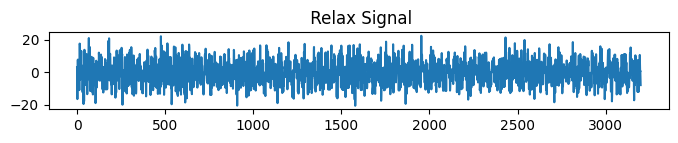

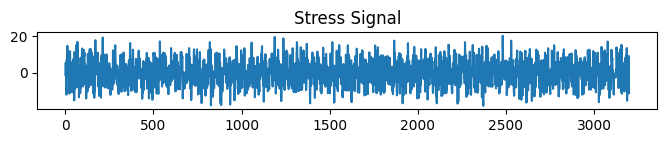

TypeError: plot_data() got an unexpected keyword argument 'save_path'

In [27]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat

# Function to reshape data and plot
def plot_data(data, title):
    reshaped_data = data.reshape((32, 3200), order='F')  # Reshape to 32x3200, using Fortran order
    #plt.figure(figsize=(8, 1))
    #plt.imshow(reshaped_data, aspect='auto', cmap='jet', extent=[0, 3200, 0, 32])
    #plt.colorbar()
    #plt.title(title)
    #plt.xlabel('Sample Index')
    #plt.ylabel('Channel Index')
    plt.show()

# Specify the channel you want to visualize
selected_channel = 0  # Adjust based on your data

# Load data from class 1
class1_data = loadmat(os.path.join( 'Relax_sub_1_trial1.mat'))
class1_signal = class1_data['Clean_data'][ selected_channel,:]
print(class1_signal.shape)
import matplotlib.pyplot as plt

def plot_data(data, title):
    plt.figure(figsize=(8, 1))
    plt.plot(data)
    plt.title(title)
    #plt.xlabel('Sample Index')
    #plt.ylabel('Signal Value')
    plt.show()

# Usage for class 1
plot_data(class1_signal, ' Relax Signal')

# Load data from class 2
class2_data = loadmat(os.path.join( 'Arithmetic_sub_1_trial1.mat'))
class2_signal = class2_data['Clean_data'][selected_channel,: ]

# Plot class 2 data
plot_data(class2_signal, 'Stress Signal')
plot_data(class1_signal, 'Relax Signal', save_path='relax_signal.png')


C:\Users\Rajveer\AppData\Local\Temp\ipykernel_11408\3300618155.py:28: RuntimeWarning: divide by zero encountered in log2
  spectral_entropy = -np.sum(power_density * np.log2(power_density))
C:\Users\Rajveer\AppData\Local\Temp\ipykernel_11408\3300618155.py:28: RuntimeWarning: invalid value encountered in multiply
  spectral_entropy = -np.sum(power_density * np.log2(power_density))


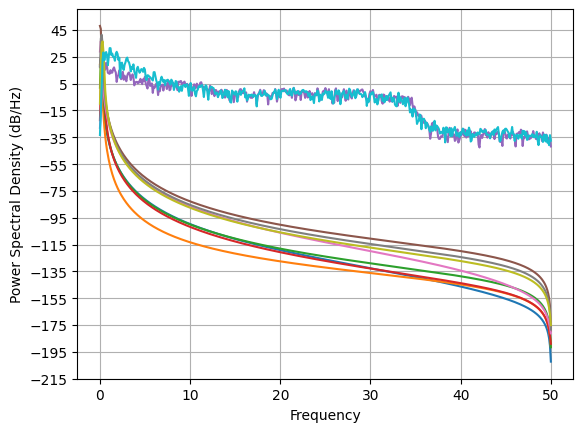

In [119]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis
from scipy.signal import find_peaks
from scipy.stats import entropy
from scipy.signal import hilbert

# Assuming ewt_modes_list contains the EWT modes for each channel
all_channel_features = []

for channel_index, ewt_modes in enumerate(ewt_modes_list[:2]):  # Iterate only for the first two channels
    channel_features = []

    for mode_index, mode in enumerate(ewt_modes.T):
        # Statistical Features
        mean_value = np.mean(mode)
        std_deviation = np.std(mode)
        median_value = np.median(mode)
        min_value = np.min(mode)
        max_value = np.max(mode)
        skewness_value = skew(mode)
        kurtosis_value = kurtosis(mode)

        channel_features.extend([mean_value, std_deviation, median_value, min_value, max_value, skewness_value, kurtosis_value])

        # Frequency Domain Features
        freq, power_density = plt.psd(mode, NFFT=1024, Fs=fs)
        spectral_entropy = -np.sum(power_density * np.log2(power_density))
        dominant_frequency = freq[np.argmax(power_density)]

        # Additional Frequency Domain Features
        spectral_energy = np.sum(power_density)
        spectral_peak = freq[np.argmax(power_density)]
        max_frequency = freq[np.argmax(power_density)]
        spectral_centroid = np.sum(freq * power_density) / np.sum(power_density)

        channel_features.extend([spectral_entropy, dominant_frequency, spectral_energy, spectral_peak, max_frequency, spectral_centroid])

        # Time-Domain Features
        amplitude_envelope = np.abs(hilbert(mode))
        instantaneous_amplitude = np.mean(amplitude_envelope)
        instantaneous_frequency = np.mean(np.angle(np.diff(np.unwrap(np.angle(hilbert(mode))))))

        channel_features.extend([instantaneous_amplitude, instantaneous_frequency])

        # Hjorth Parameters
        hjorth_mobility = np.sqrt(np.var(np.diff(mode)) / np.var(mode))
        hjorth_complexity = np.sqrt((np.var(np.diff(np.diff(mode))) / np.var(np.diff(mode))) / hjorth_mobility)

        channel_features.extend([hjorth_mobility, hjorth_complexity])

        # Other Features (add your additional feature extraction methods here)

    all_channel_features.append(channel_features)

# Now, all_channel_features is a list where each element corresponds to the features extracted from the first two channels
